In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pydicom
from collections import defaultdict

In [2]:
train_directory_path = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train'

In [3]:
train_cases = os.listdir(train_directory_path)
no_of_cases = len(train_cases)

In [4]:
count = 0
for case in train_cases:
    if count>=10: 
        break
    case_path = os.path.join(train_directory_path, case)
    print(case_path)
    count+=1
    

/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00688
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00058
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00516
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00185
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00547
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00502
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00222
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00610
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00133
/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00452


In [5]:
print(f'There are {no_of_cases} cases in the train folder.')

There are 585 cases in the train folder.


### Check for Missing Modalities

In [6]:
required_modalities = ['FLAIR','T1w','T1wCE', 'T2w']

In [7]:
def check_missing_modalities(directory_path, required_modalities):
    missing_modalities = {}
    cases = os.listdir(directory_path)

    for case in cases:
        path = os.path.join(directory_path, case)
        present_modalities = os.listdir(path)     
        for modality in required_modalities:
            if modality not in present_modalities:
                missing_modalities[case].append(modality)
            
    if not missing_modalities:
        return 'There are no missing modalities of MRI scans.'
    else:
        return missing_modalities
        
    

In [8]:
print(check_missing_modalities(train_directory_path, required_modalities))

There are no missing modalities of MRI scans.


### Check Class Distribution

In [9]:
train_labels = pd.read_csv(
    '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv',
    dtype = {'BraTS21ID': str})
train_labels.head()

,BraTS21ID,MGMT_value
0,00000,1
1,00002,1
2,00003,0
3,00005,1
4,00006,1


In [10]:
print(train_labels['MGMT_value'].unique())

[1 0]


In [11]:
list(train_labels['MGMT_value'].value_counts().values)

[307, 278]

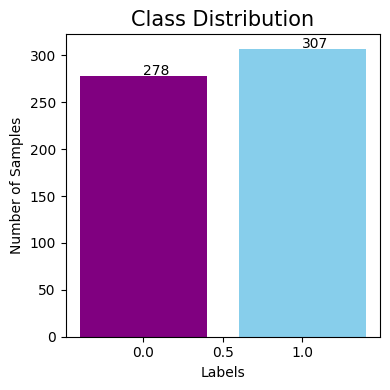

In [12]:
plt.figure(figsize = (4, 4))
bars = plt.bar(list(train_labels['MGMT_value'].unique()), 
        list(train_labels['MGMT_value'].value_counts().values),
        color = ['skyblue', 'purple'])


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height+0.5, 
             f'{int(height)}'
            )

plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution', fontsize = 15)
plt.tight_layout()
plt.show()

### Check Single Image Dimension

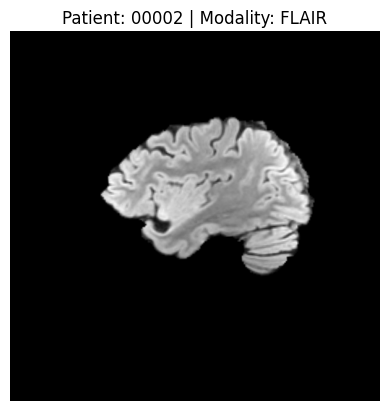

In [13]:
# Locate and read the path of the image
modality = 'FLAIR'
patient = '00002'
image_path = os.path.join(train_directory_path, patient, modality)
dicom_image_path = os.path.join(image_path, os.listdir(image_path)[0])

# Plot the image
dicom_image = pydicom.dcmread(dicom_image_path)
image = dicom_image.pixel_array
plt.imshow(image, cmap = 'gray')
plt.title(f'Patient: {patient} | Modality: {modality}')
plt.axis('off')
plt.show()

In [14]:
height, width = image.shape
print(f"Image Dimensions: {image.shape}")
print(f"Image Height: {height} pixels")
print(f"Image Width: {width} pixels")

Image Dimensions: (512, 512)
Image Height: 512 pixels
Image Width: 512 pixels


In [15]:
# Determine if grayscale or RGB
if len(image.shape) == 2:
    print("The images of this dataset are grayscale.")
elif len(image.shape) == 3 and image.shape[-1] == 3:
    print("The images are RGB (3 channels).")
else:
    print("The image has an unusual channel configuration.")

The images of this dataset are grayscale.


In [18]:
# Dictionary to group slices by SeriesInstanceUID
series_slices = defaultdict(list)

for file in os.listdir(image_path):
    filepath = os.path.join(image_path, file)
    dicom_file = pydicom.dcmread(filepath)
    series_uid = dicom_file.SeriesInstanceUID
    series_slices[series_uid].append(dicom_file)

# Check the number of slices per series
for series, slices in series_slices.items():
    print(f"Series {series} has {len(slices)} slices.")

Series 1.2.826.0.1.3680043.8.498.11080017939623954520316925248840896201 has 129 slices.


### Slice Distribution Per Case

In [19]:
summary_df = train_labels.copy()
summary_df.head()

,BraTS21ID,MGMT_value
0,00000,1
1,00002,1
2,00003,0
3,00005,1
4,00006,1


In [20]:
def count_slices(directory_path, required_modalities, summary_df):
    cases = os.listdir(directory_path)
    for case in cases:
        total_slices = 0
        case_path = os.path.join(directory_path, case)
        for modality in required_modalities:
            modality_path = os.path.join(case_path, modality)
            modality_slice_count = len(os.listdir(modality_path))
            summary_df.loc[summary_df["BraTS21ID"] == case, modality] = int(modality_slice_count)
            total_slices += modality_slice_count

        summary_df.loc[summary_df["BraTS21ID"] == case, "Total Slices"] = int(total_slices)
    return summary_df
            
print('Number of slices per modality per patient')            
count_slices(train_directory_path, required_modalities, summary_df)

Number of slices per modality per patient


,BraTS21ID,MGMT_value,FLAIR,T1w,T1wCE,T2w,Total Slices
0,00000,1,400.0,33.0,129.0,408.0,970.0
1,00002,1,129.0,31.0,129.0,384.0,673.0
2,00003,0,129.0,33.0,129.0,408.0,699.0
3,00005,1,400.0,28.0,129.0,424.0,981.0
4,00006,1,129.0,32.0,129.0,408.0,698.0
...,...,...,...,...,...,...,...
580,01005,1,23.0,23.0,23.0,23.0,92.0
581,01007,1,124.0,124.0,124.0,124.0,496.0
582,01008,1,60.0,192.0,192.0,64.0,508.0
583,01009,0,23.0,23.0,23.0,23.0,92.0


In [21]:
summary_df.head()

,BraTS21ID,MGMT_value,FLAIR,T1w,T1wCE,T2w,Total Slices
0,00000,1,400.0,33.0,129.0,408.0,970.0
1,00002,1,129.0,31.0,129.0,384.0,673.0
2,00003,0,129.0,33.0,129.0,408.0,699.0
3,00005,1,400.0,28.0,129.0,424.0,981.0
4,00006,1,129.0,32.0,129.0,408.0,698.0


In [22]:
total_images = summary_df['Total Slices'].sum().astype(int)
print(f'There are {total_images} images in the dataset in total.')

There are 348641 images in the dataset in total.


### Visualize Single Slice for Each of the Modalities for a Patient

In [23]:
def visualize_modalities(patient, required_modalities):
    
    '''
        Creates a figure and four subplots for four modalities for a patient case
        fig:  The overall figure containing the subplots.
        axes: An array of subplot axes (one for each modality).
    
    '''
    fig, axes = plt.subplots(1, len(required_modalities), figsize=(10, 5))
    
    for i, modality in enumerate(required_modalities):
        
        # Patient folder path
        patient_directory = os.path.join(train_directory_path, patient)
        
        # Modality folder path for the patient
        modality_directory = os.path.join(patient_directory, modality)
        
        # Access the first image in the list of images in the directory
        image_path = os.path.join(modality_directory, os.listdir(modality_directory)[0])
        
        # Read dicom image
        dicom_image = pydicom.dcmread(image_path)
        
        # Convert dicom image to 2D array
        dicom_image_2D = dicom_image.pixel_array

        # i denotes current modality being visualized
        axes[i].imshow(dicom_image_2D, cmap = 'gray')
        axes[i].set_title(modality)
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

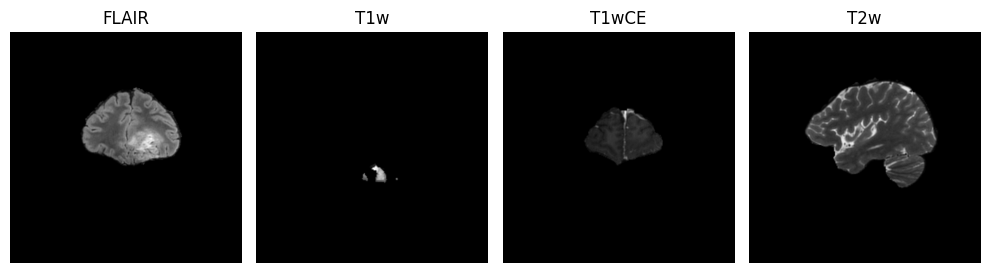

In [24]:
visualize_modalities('00000', required_modalities)

### Check for Orientation Data in Image

In [25]:
def get_image_orientation(dicom_file):
    dicom_data = pydicom.dcmread(dicom_file)
    
    # Check if the image has orientation data
    if 'ImageOrientationPatient' in dicom_data:
        orientation = dicom_data.ImageOrientationPatient
        return orientation
    else:
        return None

# Example usage
patient_id = '00000'
modality = 'FLAIR'  # You can loop through other modalities as needed
modality_path = os.path.join(train_directory_path, patient_id, modality)

# Let's check the orientation of the first image in the FLAIR folder
dicom_file = os.path.join(modality_path, os.listdir(modality_path)[0])
orientation = get_image_orientation(dicom_file)

if orientation:
    print(f"Orientation of the image: {orientation}")
else:
    print("Orientation data not available in this DICOM file.")


Orientation of the image: [1, -0, 0, -0, -0, -1]
